# HDD Predictive Maintenance - Felix - EDA

This notebook covers the exploratory data analysis part for the predictive maintenance of hard disk drives in data centers project.

The dataset is a excerpt from the data published by Backblaze: https://www.backblaze.com/b2/hard-drive-test-data.html. It contains:
* all drives of a certain model: Seagate ST4000DM000 that failed in 2020 or 2021
* daily reported drive stats for those drives between 2019 and drive failure

In this notebook, we investigate the structure of the data, we clean it and we have a first look at the content. The structure is inspired by: https://miykael.github.io/blog/2022/advanced_eda/.

The notebook is structured as follows:
1. Structure
2. Data quality
3. Content
4. Outlook

At the end of the notebook we hopefully have a few ideas for feature engineering and the modeling.

### Setup workspace and load data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.feature_selection import mutual_info_classif

import missingno as msno

RSEED = 42

In [2]:
df = pd.read_csv("../../data/raw/ST4000DM000_history_total.csv", parse_dates=["date"])

# 1. Structure

First, we examine the structure of the dataset and look at the distribution of column types.

In [3]:
df_backup = df.copy() # Backup the original dataframe
print("Shape of the dataframe:", df.shape)
print("Distribution of column types:")
pd.value_counts(df.dtypes)

Shape of the dataframe: (463089, 179)
Distribution of column types:


float64           174
object              2
int64               2
datetime64[ns]      1
dtype: int64

We have 179 columns:
* 1 datetime (date)
* 2 object types (model and serial_number)
* 2 int64 (failure/target and capacity_bytes)
* 174 float64 (S.M.A.R.T. characteristics)

## 1.1 Non-numerical features

The two object type columns are the `serial_number` identifying the individual drives and the `model`. The model is the same for the whole dataset.

In [4]:
df.select_dtypes(exclude="number").head()

,date,serial_number,model
0,2020-09-18,Z304JG86,ST4000DM000
1,2020-09-18,S301GMGZ,ST4000DM000
2,2020-09-18,S300YQTN,ST4000DM000
3,2020-09-18,Z302T8AB,ST4000DM000
4,2020-09-18,Z302SXFH,ST4000DM000


In [5]:
df.describe(exclude='number', datetime_is_numeric=True)

,date,serial_number,model
count,463089,463089,463089
unique,NaN,608,1
top,NaN,Z304GSQ0,ST4000DM000
freq,NaN,1096,463089
mean,2020-02-16 07:05:18.923576320,NaN,NaN
min,2019-01-01 00:00:00,NaN,NaN
25%,2019-07-10 00:00:00,NaN,NaN
50%,2020-01-18 00:00:00,NaN,NaN
75%,2020-08-29 00:00:00,NaN,NaN
max,2021-12-31 00:00:00,NaN,NaN


Some findings:
* **date**: The timespan covers `2019-01-01` - `2021-12-31`. The median is not in the middle of the timeframe, since drives are failing but no new drives are added to the dataset over time.
* **serial_number**: There are 608 unique drives in the dataset
* **model**: All the data is for one model

## 1.2 Numerical features

How many unique values are reported for the S.M.A.R.T. characteristics? How many empty columns do we have?  This gives us some insights about the number of binary (2 unique values), ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

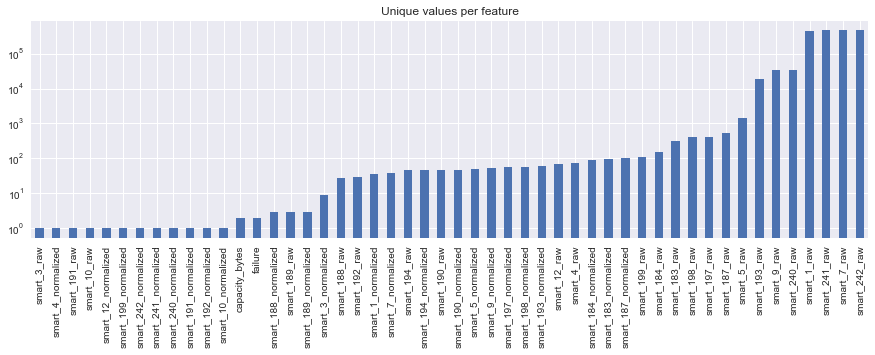

In [6]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(include="number").nunique().sort_values()
# Only show numerical features with reported values
unique_values = unique_values[unique_values > 0]
# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

* 50 columns contain values
* `smart_191` and `smart_10` report only one value for both the normalized and the raw columns
* `smart_3` reports only one value for raw, but several different values for normalized
* `smart_4/12/192/199/240/241/242` report one value for normalized but several values for raw
* `capacity_bytes` reports 2 values, but the model should only contain 1 value (actually it reports -1 if the row contains only NaNs). This helps us to identify errors in the data.
* A lot of S.M.A.R.T. characteristics are continuous
* There is a discrepancy between the normalized and the raw values, we have to look deeper into this later.

# 2. Data quality

Here we have a look on the general quality of the dataset. We identify duplicates, missing values and recording errors. We clean the data and remove unwanted observations and drop some empty columns.

## 2.1. Duplicates

Check for duplicates and remove them:

In [7]:
# Check number of duplicates
n_duplicates = df.duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 167 duplicates in your database.


In [8]:
# # Suppose we have an index feature "Id" that we want to ignore when looking for duplicates:
# columns_to_consider = df.drop(labels=["Id"], axis=1).columns
# df = df.drop_duplicates(subset=columns_to_consider)
df = df.drop_duplicates()
print(f"Shape after dropping of duplicates: {df.shape}")

Shape after dropping of duplicates: (462922, 179)


167 duplicates seem reasonable in the dataset. They might come from the uploading to the SQL database or even be present in the backblaze data.

## 2.2. Missing values

Here we want to see if we have big holes in the dataset. We look for samples or features with a lot of missing values. For this we use the `missingno` library.


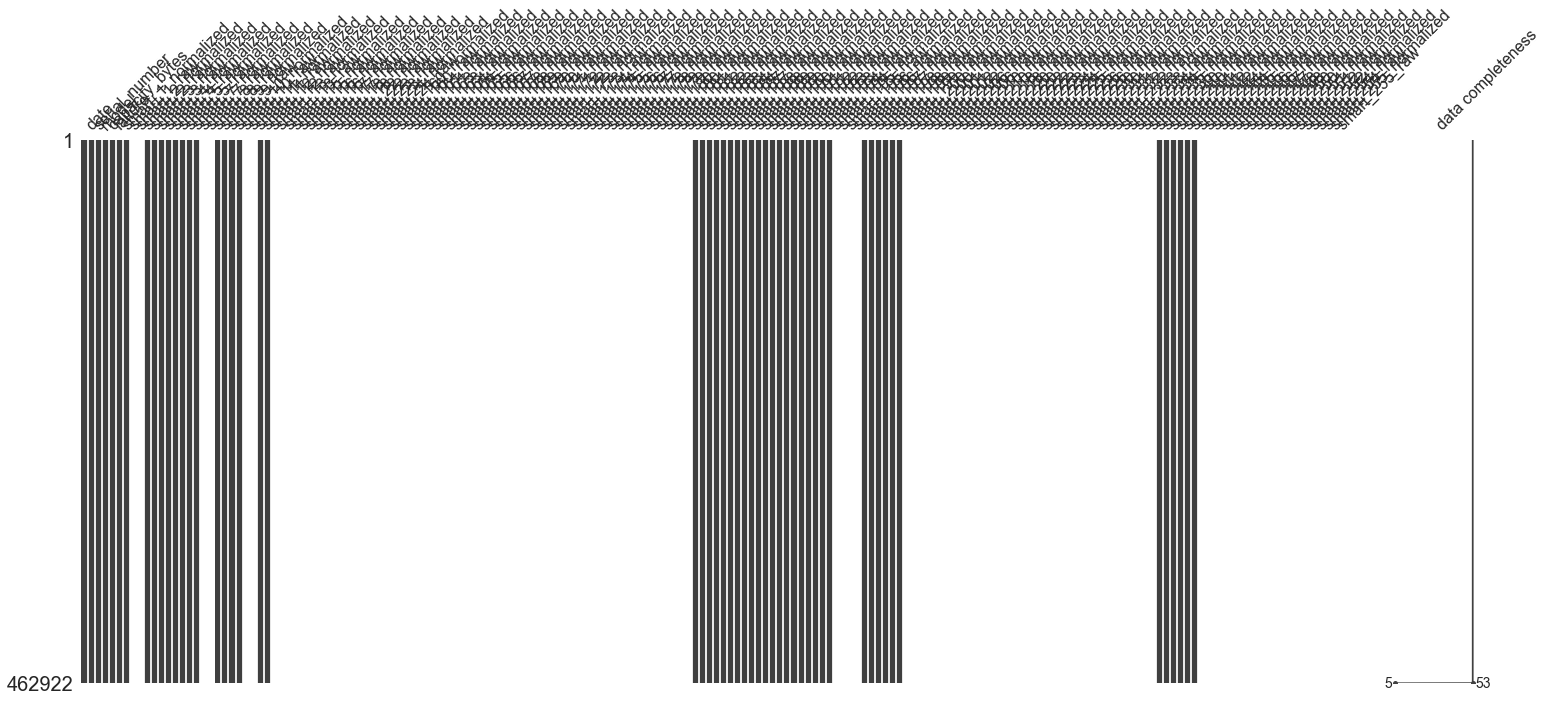

In [9]:
msno.matrix(df, labels=True, sort="descending");

A lot of columns only contain missing values. Additionally we have a few rows with a lot of missings. Let's look on the missing percentage per feature:

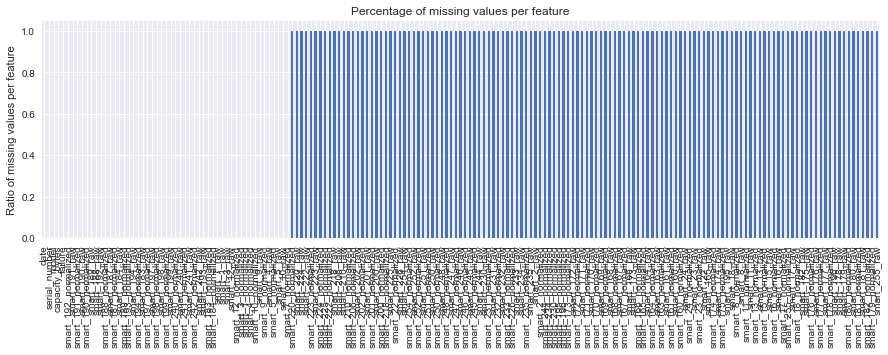

In [10]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

Again, we see that a lot of S.M.A.R.T. charactersitics are not reported for this drive model. Therefore, we kick out columns with more than 85% missings.

In [11]:
df = df.dropna(thresh=df.shape[0] * 0.85, axis=1)
print("Shape after removal of empty columns:", df.shape)

Shape after removal of empty columns: (462922, 53)


Additionally, we drop the rows with more than 80% missing values:

In [12]:
df = df.dropna(thresh=df.shape[1] * 0.80, axis=0).reset_index(drop=True)
print("Shape after removal of empty rows:", df.shape)

Shape after removal of empty rows: (462881, 53)


This tremendously reduced the number of features, which is nice!

We only removed the big holes in the data, individual missings might still be present.

In [13]:
df.isna().any().sum()

0

## 2.3. Recording errors

We check for plausibility of outliers to identify unwanted entries and recording errors. Therefore, we look into global patterns.

### 2.3.1 Numerical Features

We plot all observations in one subplot per feature. Observations are marked with a dot to be able to distinguish them.

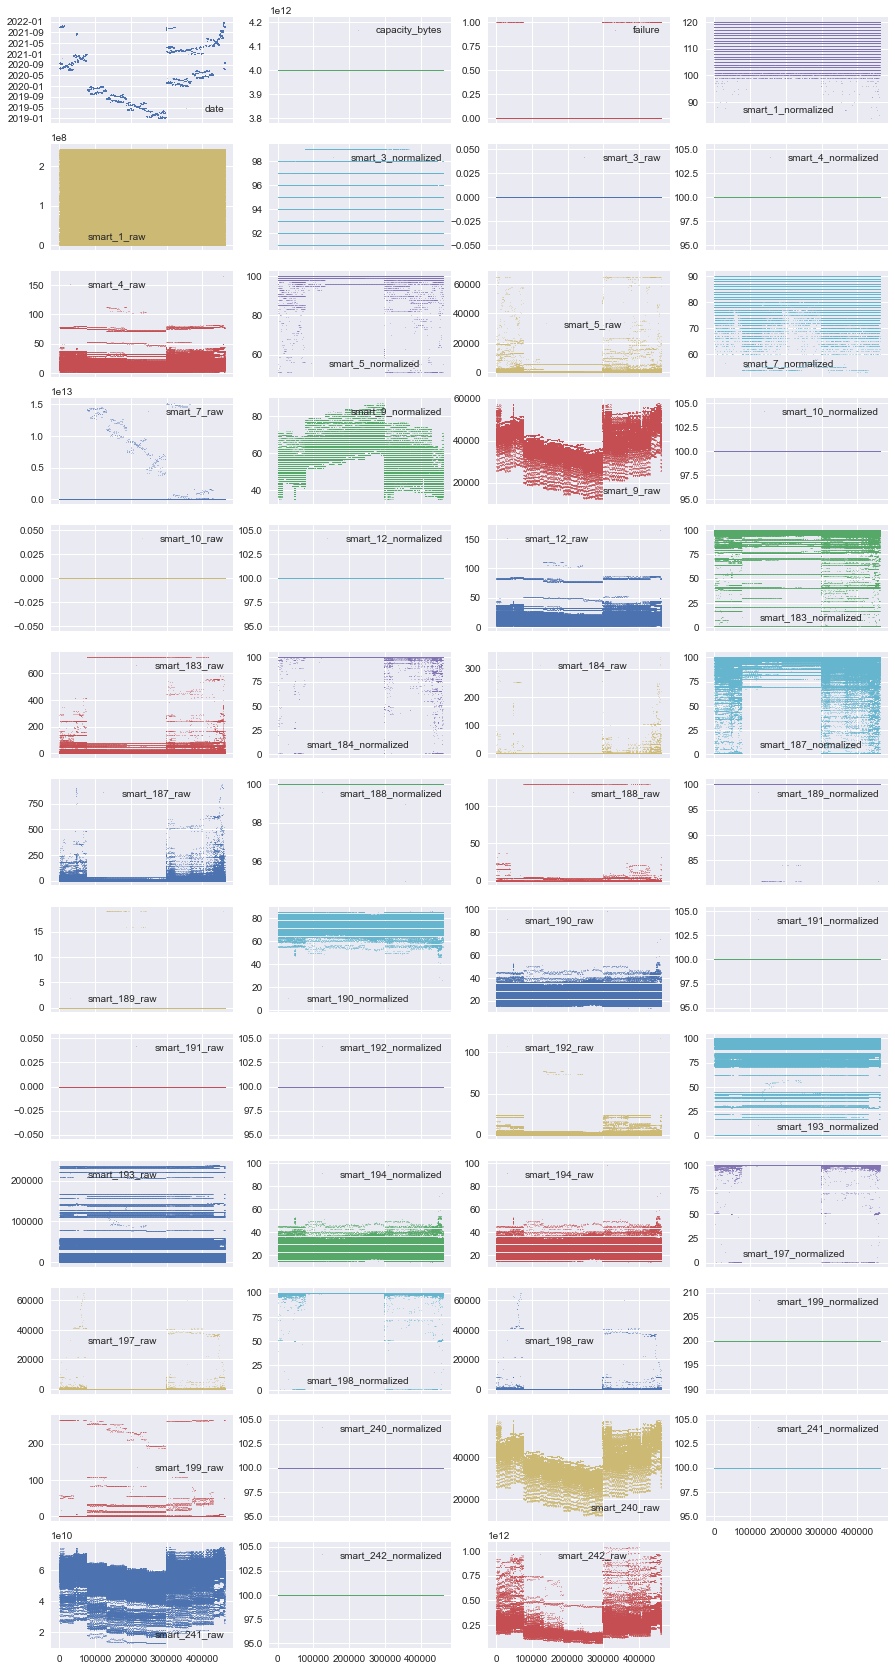

In [14]:
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

* Due to the way, the data is sorted, we see a difference between failing and non-failing drives in many features
* In general, outliers seem to be connected with drive failure
* `smart_7` report some very strong outliers, we should check that
* For some features, the connection between the normalized and the raw values is very strange

**TODO**: More data cleaning

### 2.3.2. Non-numerical features

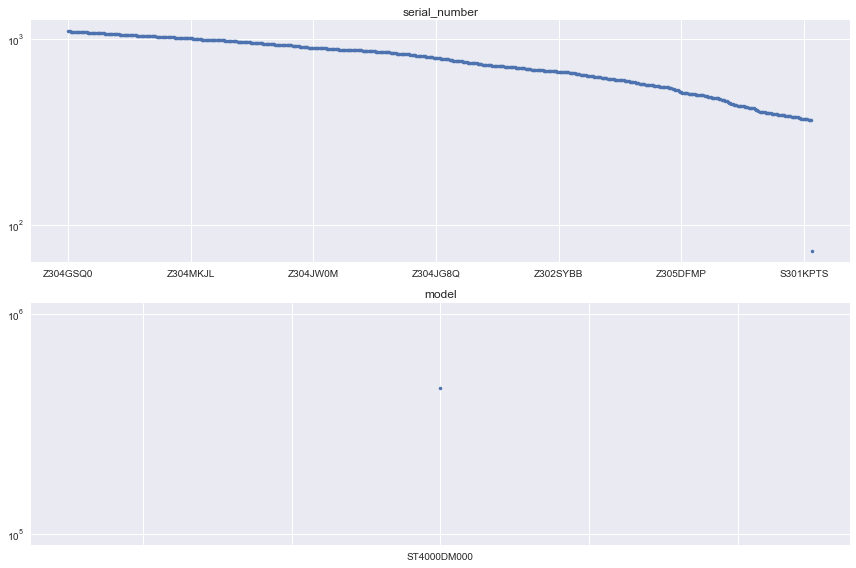

In [15]:
# Create figure object with 2 subplots
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))
# Identify non-numerical features
df_non_numerical = df.select_dtypes(exclude=["number", "datetime"])
# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(
        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
plt.tight_layout();

* The steady decrease in observations per serial number is linked to the fact, that drives fail continuously.
* The drive `Z30149L0` has below 100 rows. This is strange as the drives should have at least 1 year of data.

In [16]:
df = df[df.serial_number != "Z30149L0"]
print("Shape after removal of the faulty HDD:", df.shape)

Shape after removal of the faulty HDD: (462809, 53)


# 3. Content

**Description of the features**
- **`date`**: datetime
- **`serial_number`**: unique identifier
- **`model`**: model number
- **`failure`**: target
- **`capacity`**: HDD capacity in TB
- `smart1`: read error rate
- `smart3`: spin-up time
- `smart4`: start-stop count
- `smart5`: reallocated sectors count, **CRITICAL**
- `smart7`: seek error rate
- `smart9`: power on hours (expected: 5 years corresponds to 43 800 hours)
- `smart10`: spin retry count, **CRITICAL**
- `smart12`: power cycle count
- `smart183`: Seagate: downshift error count (sign of aging but no direct indicator)
- `smart184`: end-to-end-error, **CRITICAL**
- `smart187`: uncorrectable errors, **CRITICAL**
- `smart188`: command timeout, should be zero, **CRITICAL**
- `smart189`: high fly writes
- `smart190`: temperature difference, 100°C - temp, here: same values as `smart194`
- `smart191`: g-sense error rate (externally induced shock, vibration)
- `smart192`: unsafe shutdown count
- `smart193`: load cycle count (power saving, rated for 300 000 to 600 000)
- `smart194`: temperature
- `smart197`: count of unstable sectors, **CRITICAL**
- `smart198`: count of uncorrectable sectors, **CRITICAL**
- `smart199`: error count for transfer with interface cable, here always 0!
- `smart240`: head flying hours
- `smart241`: total LBA written
- `smart242`: total LBA read

## 3.1. Feature distribution

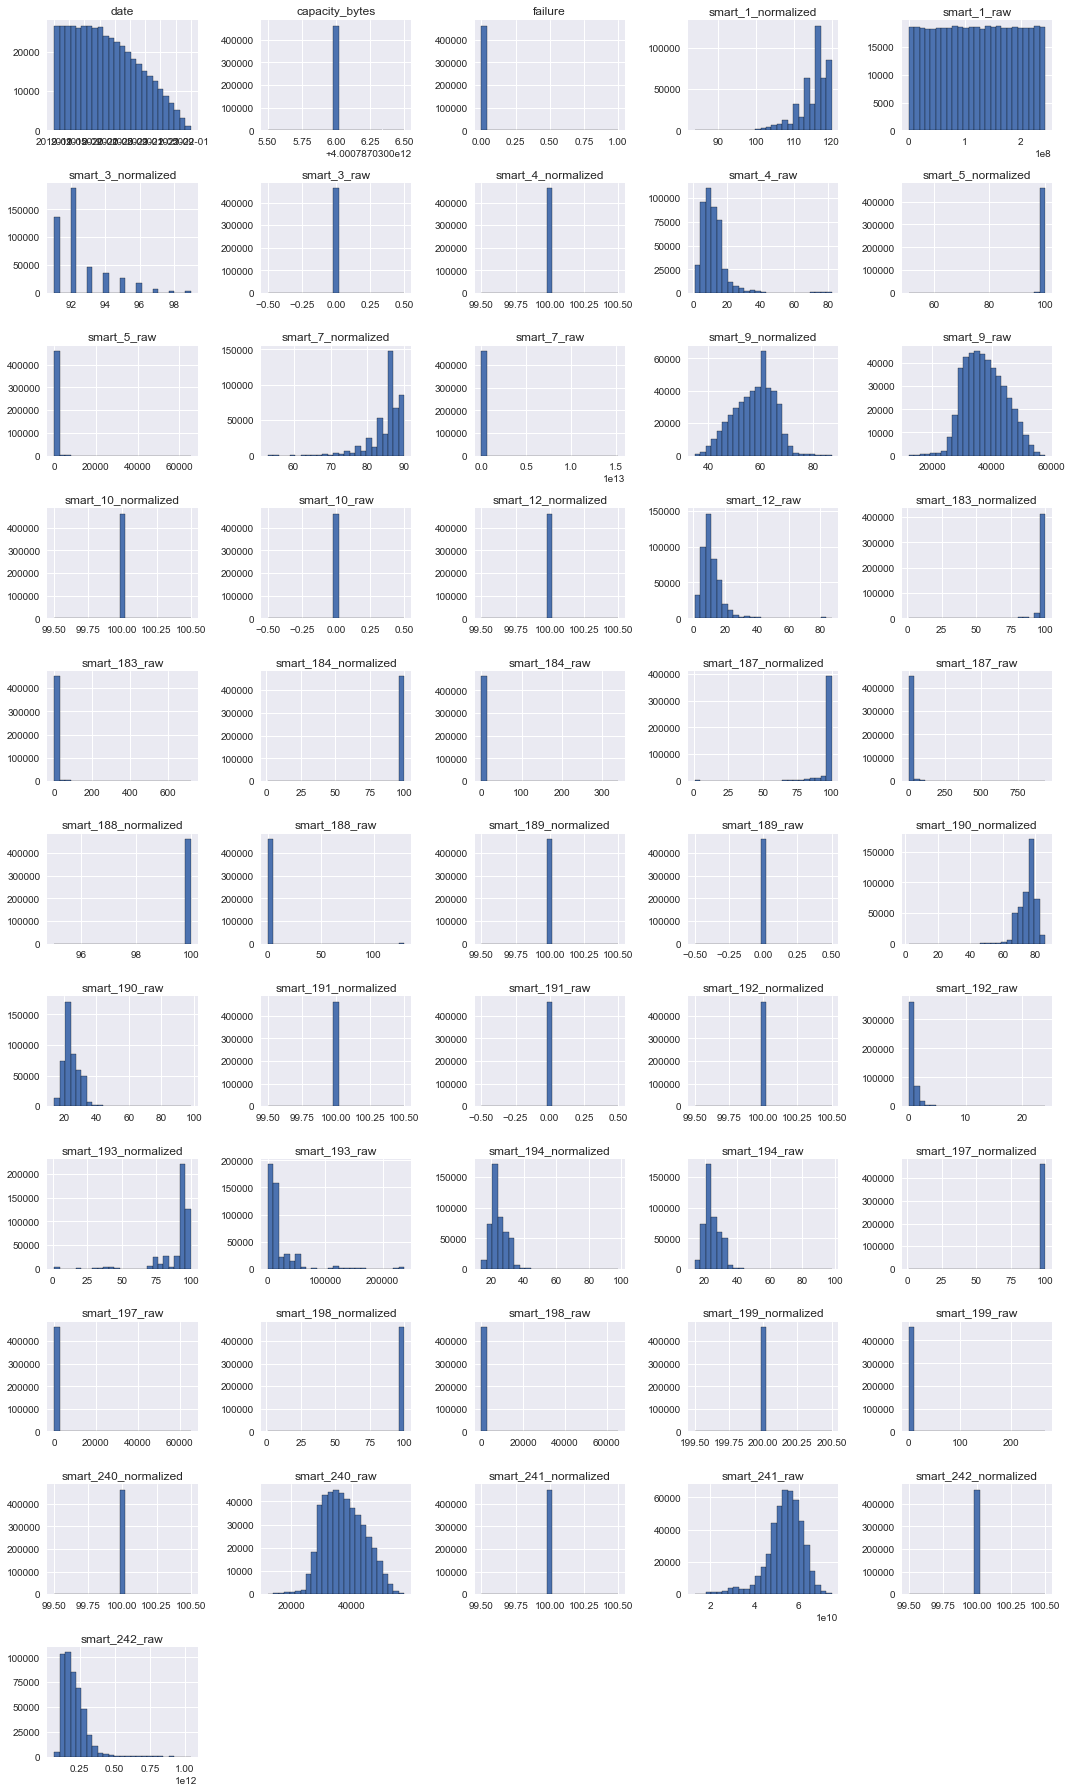

In [17]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

* Many skewed distributions, we should definitely consider scaling
* Again the relation between the normalized and the raw columns is not always clear

smart_199_normalized    1.0
smart_12_normalized     1.0
smart_10_normalized     1.0
smart_240_normalized    1.0
smart_241_normalized    1.0
dtype: float64


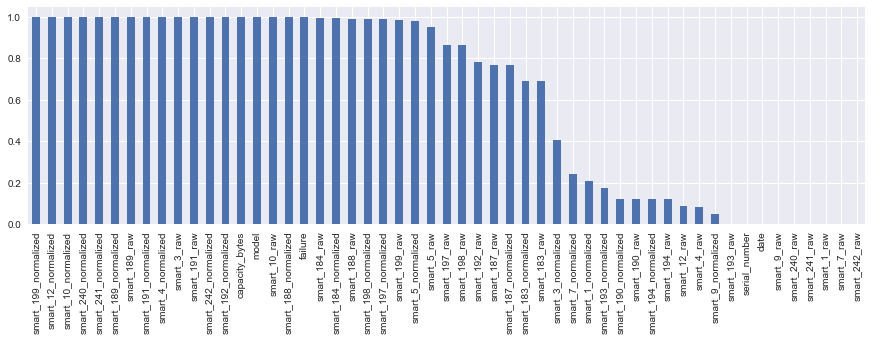

In [18]:
# Collects for each feature the most frequent entry
most_frequent_entry = df.mode()
# Checks for each entry if it contains the most frequent entry
df_freq = df.eq(most_frequent_entry.values[0,:], axis=1)
# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)
# Show the 5 top features with the highest ratio of singular value content
print(df_freq.head())
# Visualize the 'df_freq' table
df_freq.plot.bar(figsize=(15, 4));

* All features with 100% in the mode can be neglected for the modeling
* `smart_5_normalized` and `smart_199_raw` might be good to detect outliers (failing drives)

## 3.2. Feature patterns

In [19]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df.select_dtypes(include="number").nunique() >= 25

### 3.2.1. Continuous features

In [20]:
# Create a new dataframe which only contains the continuous features
df_continuous = df[cols_continuous[cols_continuous].index]
print("Shape of continuous features:", df_continuous.shape)

Shape of continuous features: (462809, 32)


Use pairplot with up to around 10 features

In [21]:
# sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

### 3.2.2. Discrete features

In [22]:
# Create a new dataframe which doesn't contain the numerical continuous features
df_discrete = df[cols_continuous[~cols_continuous].index]
print("Shape of discrete features:", df_discrete.shape)

Shape of discrete features: (462809, 18)


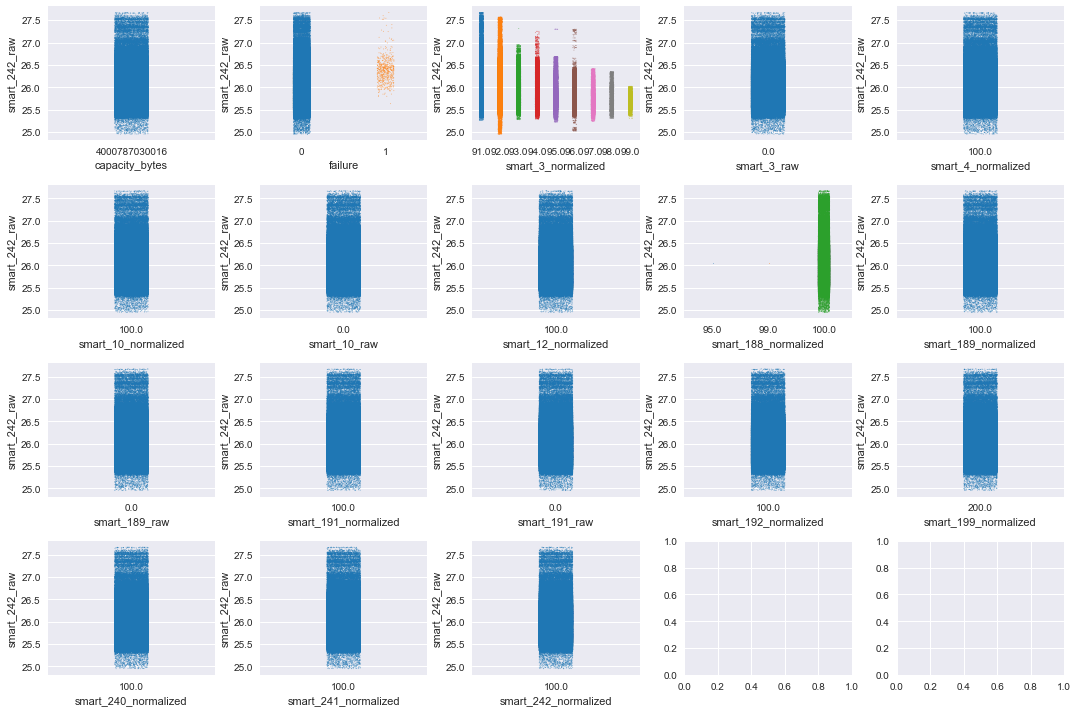

In [23]:
# Establish number of columns and rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")
# Specify y_value to spread data (ideally a continuous feature)
y_value = np.log(df["smart_242_raw"]+1)
# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))
# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout();

## 3.3. Feature correlation

In [24]:
df_corr = df.corr(method="pearson")

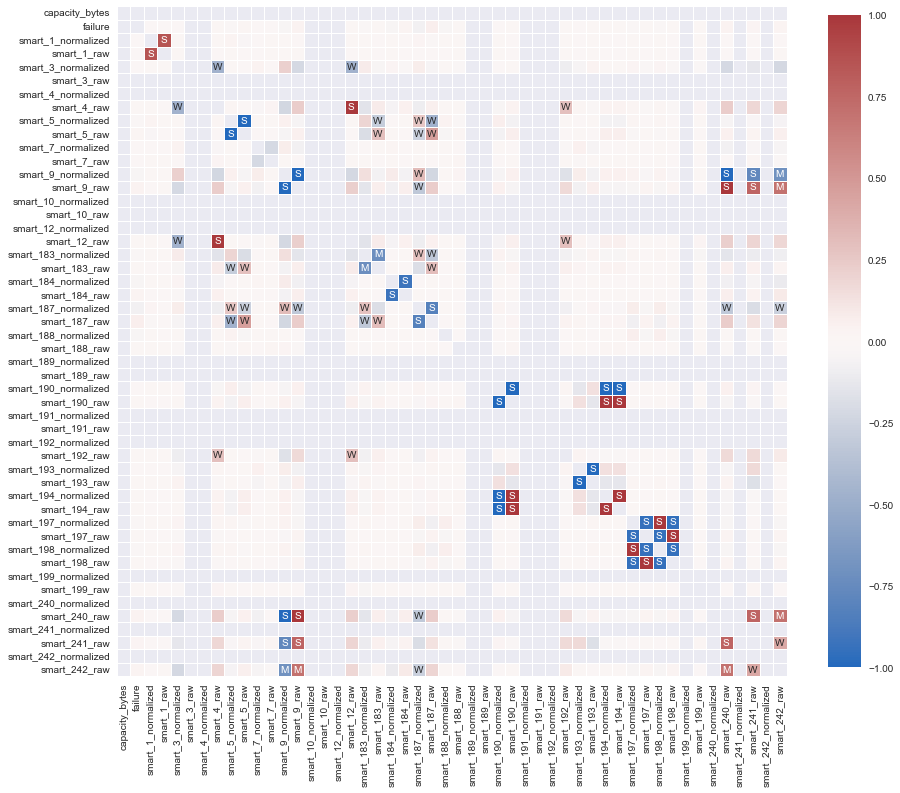

In [25]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [26]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")
#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()
#  Showing the lowest and highest correlations in the correlation matrix
print(df_corr_stacked)

smart_194_raw         smart_190_normalized   -1.000000
smart_194_normalized  smart_190_normalized   -1.000000
smart_190_raw         smart_190_normalized   -1.000000
smart_9_raw           smart_9_normalized     -0.999315
smart_240_raw         smart_9_normalized     -0.997089
                                                ...   
smart_198_normalized  smart_197_normalized    1.000000
smart_194_raw         smart_194_normalized    1.000000
                      smart_190_raw           1.000000
smart_194_normalized  smart_190_raw           1.000000
smart_198_raw         smart_197_raw           1.000000
Length: 595, dtype: float64


Overall, we found a lot of correlations between different features.

# 4. Conclusion

To sum up:
* We have slightly above 50 features
* The connection between raw and normalized values needs to be studied in more detail
* We should use `smart_3_normalized` instead of the raw, for the others raw is probably more useful
* There are very few recording errors and a few duplicates that we removed
* `smart_7` seems capped, with clear outlier drives. This will be investigated in the feature engineering notebook
* There seems to be a connection between several features
* Failing drives seem to report more outliers for different S.M.A.R.T. characteristics